In [1]:
import re
import json

import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas

import datasets

# Obtaining ISO country code

In [2]:
# parse iso coutry code from html
with open('data/iso_a3.txt', 'r') as input_:
    html = input_.read()
soup = BeautifulSoup(html, 'html.parser')
table = []
for tr in soup.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.string)
    table.append(row)

iso_a3 = pd.DataFrame(table, columns=['English short name', 'French short name', 'Alpha-2 code', 'Alpha-3 code', 'Numeric'])
iso_a3.head()

,English short name,French short name,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,Afghanistan (l'),AF,AFG,004
1,South Africa,Afrique du Sud (l'),ZA,ZAF,710
2,Albania,Albanie (l'),AL,ALB,008
3,Algeria,Algérie (l'),DZ,DZA,012
4,Germany,Allemagne (l'),DE,DEU,276


In [3]:
# mapping from index in the datasets to iso English short name
with open('data/iso_mapping.json', 'r') as i:
    mapping = json.load(i)

# Loading datasets

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

In [9]:
df_tracker = datasets.virus_tracker()
df_tracker.sort_values('Cases', ascending=False).head()

,Cases,Recovered,Unresolved,Deaths,New_Cases_Today,New_Deaths_Today,Active_Cases,Serious_Cases
Country,,,,,,,,
USA,332993,17018,0,9528,21636,1076,306447,8623
Spain,130759,38080,0,12418,4591,471,80261,6861
Italy,128948,21815,0,15887,4316,525,91246,3977
Germany,100009,28700,0,1575,3917,131,69734,3936
France,92839,16183,0,8078,2886,518,68578,6838


In [10]:
def mapper(country):
    if country in mapping:
        return mapping[country]
    return country

# conform with iso country name
# datasets are merges with iso_a3 on country code
df_tracker.rename(index=mapper, inplace=True)

In [11]:
# world should be merged with the (datasets, iso_a3) on iso_a3
(world.shape,
 world.merge(iso_a3, left_on='iso_a3', right_on='Alpha-3 code').shape,
 world.merge(iso_a3, left_on='name', right_on='English short name').shape)

((176, 6), (171, 11), (137, 11))

## Names that are not found in ISO mapping

In [12]:
set(df_tracker.index) - set(iso_a3['English short name'])

{'Diamond Princess',
 'Ivory Coast',
 'Kosovo',
 'Republic of Kosovo',
 'Swaziland'}

# Merging DataFrames

In [13]:
intermediate = df_tracker.merge(iso_a3[['English short name', 'Alpha-3 code']],
                                left_index=True, right_on='English short name', how='left')
final = world[['iso_a3', 'geometry']].merge(intermediate,left_on='iso_a3',
                                            right_on='Alpha-3 code',how='left')
final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   iso_a3              179 non-null    object  
 1   geometry            179 non-null    geometry
 2   Cases               171 non-null    float64 
 3   Recovered           171 non-null    float64 
 4   Unresolved          171 non-null    float64 
 5   Deaths              171 non-null    float64 
 6   New_Cases_Today     171 non-null    float64 
 7   New_Deaths_Today    171 non-null    float64 
 8   Active_Cases        171 non-null    float64 
 9   Serious_Cases       171 non-null    float64 
 10  English short name  171 non-null    object  
 11  Alpha-3 code        171 non-null    object  
dtypes: float64(8), geometry(1), object(3)
memory usage: 18.2+ KB


# Plotting

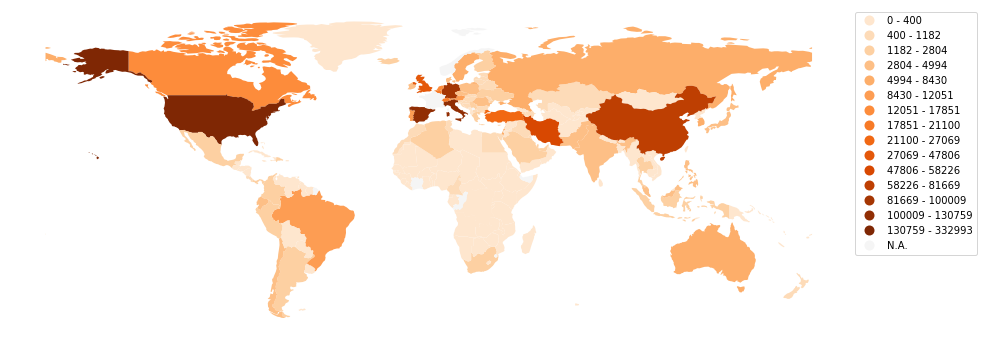

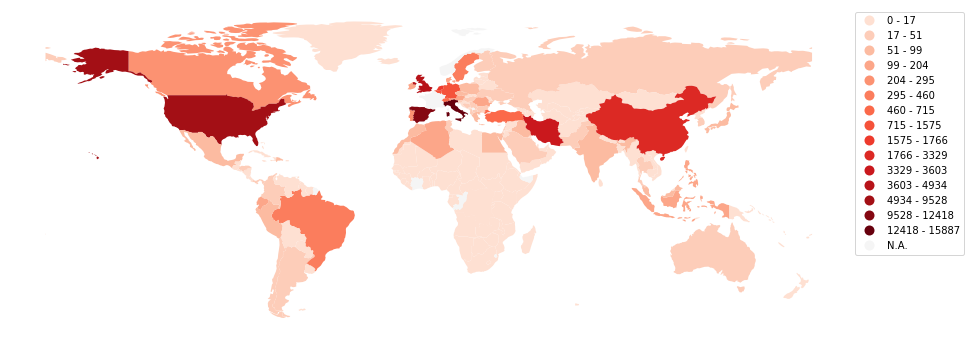

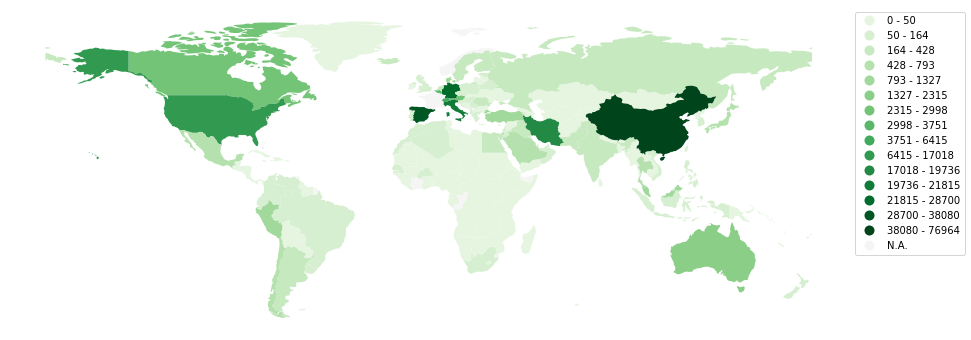

In [27]:
ws = re.compile('\.\d{2}')

def plot_map(data, category, cmap):
    fig, ax = plt.subplots(figsize=(18, 6))
    data.plot(column=category, ax=ax, legend=True, scheme='NaturalBreaks', k=15, cmap=cmap, vmin=-2,
              missing_kwds={"color": "whitesmoke"},
              legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)})
#     ax.set_title(category)
    ax.axis('off')
    legend = ax.get_legend()
    for text in legend.get_texts():
        if text.get_text() == 'NaN':
            text.set_text('N.A.')
        text.set_text(re.sub(ws, '', text.get_text()))
    plt.savefig(f'global/{category.lower()}_map.png', bbox_inches='tight')
    plt.show()

plot_map(final, 'Cases', 'Oranges')
plot_map(final, 'Deaths', 'Reds')
plot_map(final, 'Recovered', 'Greens')